## Spectral QC on Homer GCI DAS data

originally: Ethan Williams (2023-03-18)

update: Marine Denolle (2024-01-03)



In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../src/')
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import detrend
from obspy.signal.filter import bandpass as bp
from obspy import UTCDateTime
import psf_module as psf


os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## where is the data

In [2]:
dir0='/Users/marinedenolle/homer'
fdir = dir0+'/data_kkfln/'

In [3]:
flist = np.array(os.listdir(fdir))

ftime = np.array([psf.get_tstamp(fname) for fname in flist])
index = np.argsort(np.array(ftime)-ftime[0])
flist = flist[index]
ftime = ftime[index]
print(flist)

['decimator2_2024-01-03_21.02.06_UTC.h5'
 'decimator2_2024-01-03_21.03.06_UTC.h5'
 'decimator2_2024-01-03_21.04.06_UTC.h5'
 'decimator2_2024-01-03_21.05.06_UTC.h5'
 'decimator2_2024-01-03_21.06.06_UTC.h5'
 'decimator2_2024-01-03_21.07.06_UTC.h5'
 'decimator2_2024-01-03_21.08.06_UTC.h5'
 'decimator2_2024-01-03_21.09.06_UTC.h5'
 'decimator2_2024-01-03_21.10.06_UTC.h5'
 'decimator2_2024-01-03_21.11.06_UTC.h5'
 'decimator2_2024-01-03_21.12.06_UTC.h5'
 'decimator2_2024-01-03_21.13.06_UTC.h5'
 'decimator2_2024-01-03_21.14.06_UTC.h5'
 'decimator2_2024-01-03_21.15.06_UTC.h5'
 'decimator2_2024-01-03_21.16.06_UTC.h5']


### Check acquisition parameters

In [4]:
fname = flist[0]
with h5py.File(os.path.join(fdir,fname),'r') as fp:
    GL = fp['Acquisition'].attrs['GaugeLength']
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    ns = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
    #data = fp['Acquisition']['Raw[0]']['RawData'][:]
    print(fname)
    print('Gauge length (m):',GL)
    print('Channel spacing (m):',dx)
    print('Sampling rate (Hz):',fs)
    print('Num channels:',nx)
    print('Num samples:',ns)

decimator2_2024-01-03_21.02.06_UTC.h5
Gauge length (m): 23.928572013009905
Channel spacing (m): 9.571428805203961
Sampling rate (Hz): 25.0
Num channels: 10664
Num samples: 1500


# First plot of the filtered data

### Viz the data

In [5]:
fmin=1.
fmax=10.

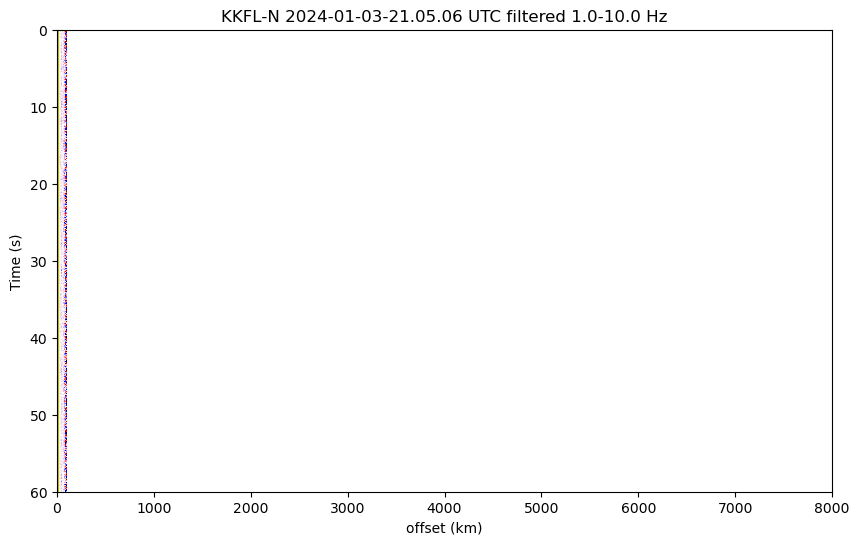

In [6]:
file = fdir+flist[3]
fname = os.path.basename(file)
starttime= ("-").join(fname.split('_')[1:3])
fac=1 # downsampling factor
tv = psf.data_visualizer(file,fac)
tv.filter_data(fmin,fmax)   
tv.plot_data(xlims=[0,80],ylims=[60,0],clims=[-1,1],srcx=0)
plt.title('KKFL-N '+starttime + ' UTC filtered ' +str(fmin)+'-'+str(fmax)+' Hz')
plt.savefig(dir0+'/plots/'+fname[:-3]+'.png')

## Characterize PSD of ambient field

In [7]:
# Example noise PDF for channel 100
# ns = 1500
chid = 1000 

In [8]:
H,xm,ym = psf.noise_PDF(fdir,flist,ns,chid,fmin,fmax)
xm,mn,vr = psf.noise_stats(H,xm,ym)

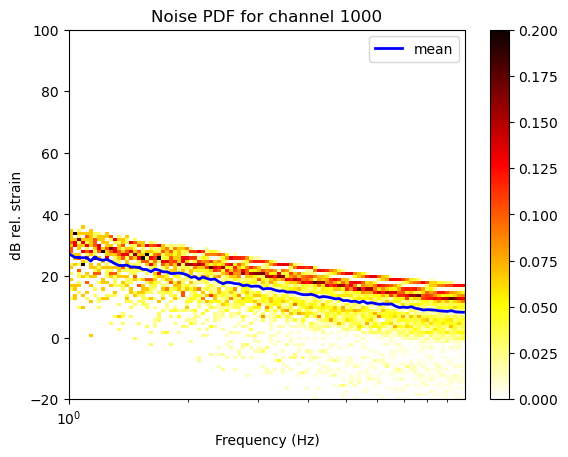

In [9]:
plt.figure()
plt.pcolormesh(xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2)
plt.plot(xm,mn,'b',linewidth=2,label='mean')
plt.gca().set_xscale('log')
# plt.xlim([min(xm),max(xm)])
plt.ylim([-20,100])
plt.colorbar()
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB rel. strain')
plt.title('Noise PDF for channel %d' % chid)
plt.legend(loc='upper right')

In [10]:
# Get mean and variance for all channels
nx = 200
chs = np.arange(nx)
x = chs * dx
files = flist

for ix, chid in enumerate(chs):
    print(ix+1,nx)
    xm,mn,vr = noise_stats(*noise_PDF(fdir,files,ns,chid,fmin,fmax))
    if ix == 0:
        mns = np.zeros((nx,len(mn)))
        vrs = np.zeros((nx,len(vr)))
    mns[ix,:] = mn
    vrs[ix,:] = vr

1 200


NameError: name 'noise_stats' is not defined

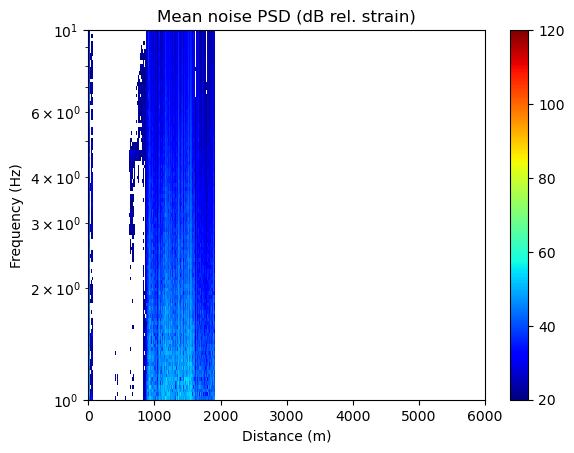

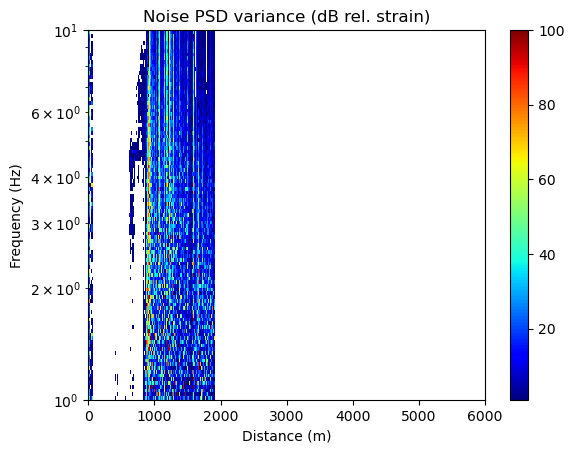

In [ ]:
plt.figure()
plt.pcolormesh(x,xm,mns.T,cmap='jet',vmin=20,vmax=120)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,6000])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean noise PSD (dB rel. strain)')
plt.colorbar()

plt.figure()
plt.pcolormesh(x,xm,vrs.T,cmap='jet',vmin=1,vmax=100)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,6000])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Noise PSD variance (dB rel. strain)')
plt.colorbar()

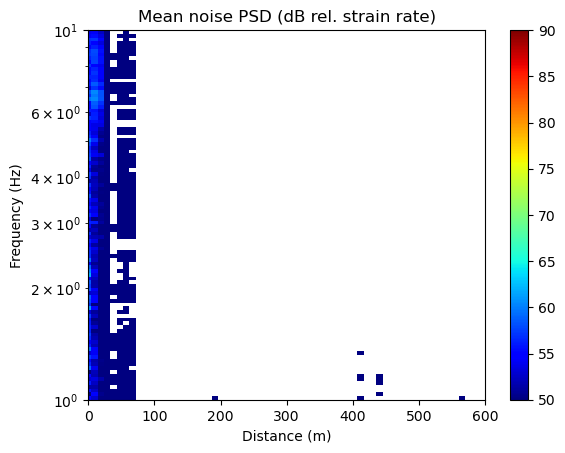

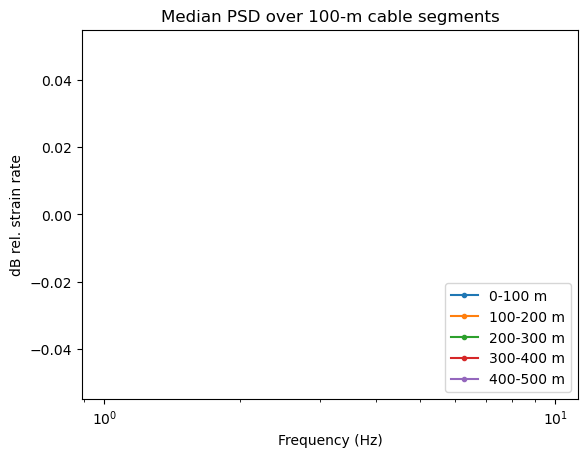

In [ ]:
# Rescale to strain rate for better visualization
f_ = np.tile(xm,(len(x),1))
mn_rate = mns + 20*np.log10(f_)

plt.figure()
plt.pcolormesh(x,xm,mn_rate.T,cmap='jet',vmin=50,vmax=90)
plt.gca().set_yscale('log')
plt.ylim([fmin,fmax])
plt.xlim([0,600])
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean noise PSD (dB rel. strain rate)')
plt.colorbar()

plt.figure()
plt.plot(xm,np.median(mn_rate[np.logical_and(x>0,x<100),:],axis=0),label='0-100 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>100,x<200),:],axis=0),label='100-200 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>200,x<300),:],axis=0),label='200-300 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>300,x<400),:],axis=0),label='300-400 m',marker='.')
plt.plot(xm,np.median(mn_rate[np.logical_and(x>400,x<500),:],axis=0),label='400-500 m',marker='.')
plt.gca().set_xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('dB rel. strain rate')
plt.title('Median PSD over 100-m cable segments')
plt.legend(loc='lower right')